AUTHOR: MATTEO FOSSATI

NOTEBOOK FOR CLASSIFYING galaxy mergers with galaxy images in various bands and using CNNs

You will see an exercise of building, compiling, and training a CNN on syntetic astronomical imaging data.

Load the data and visualize a sample of the data.

1) Divide the data into training, validation, and testing sets.

2) Build a CNN in Keras.

3) Compile the CNN.

4) Train the CNN to perform a classification task.

5) Evaluate the results.

CNNs can be applied to a wide range of image recognition tasks, including classification and regression. In this notebook, we will build, compile, and train CNN to classify whether a galaxy has undergone a merger, using simulated Hubble and James Webb Space Telescopes images of galaxies.



In [47]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback, ModelCheckpoint

# sklearn (for machine learning)
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [48]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [49]:
%%time
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

CPU times: user 404 µs, sys: 598 µs, total: 1 ms
Wall time: 821 µs


In [50]:
hdu[0].header


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   75                                                  
NAXIS2  =                   75                                                  
NAXIS3  =                    3                                                  
NAXIS4  =                15426                                                  
EXTEND  =                    T                                                  
NAME1   = 'ImageX  '                                                            
NAME2   = 'ImageY  '                                                            
NAME3   = 'filter  '           / F814W,F356W,F160W                              
NAME4   = 'object  '                                                            
EXTNAME = 'Images  '        

In [51]:
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                    8 / length of dimension 1                          
NAXIS2  =                15426 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    1 / number of table fields                         
TTYPE1  = 'MergerLabel'                                                         
TFORM1  = 'D       '                                                            
EXTNAME = 'MergerLabel'                                                         

Filters are F814W (814 nm, Optical Wavelenghts) from the Advanced Camera for Surveys, F160W (1600 nm, near-infrared) from the Wide Field Camera 3 and F356W (3560 nm, medium-infrared) from NirCAM on JWST

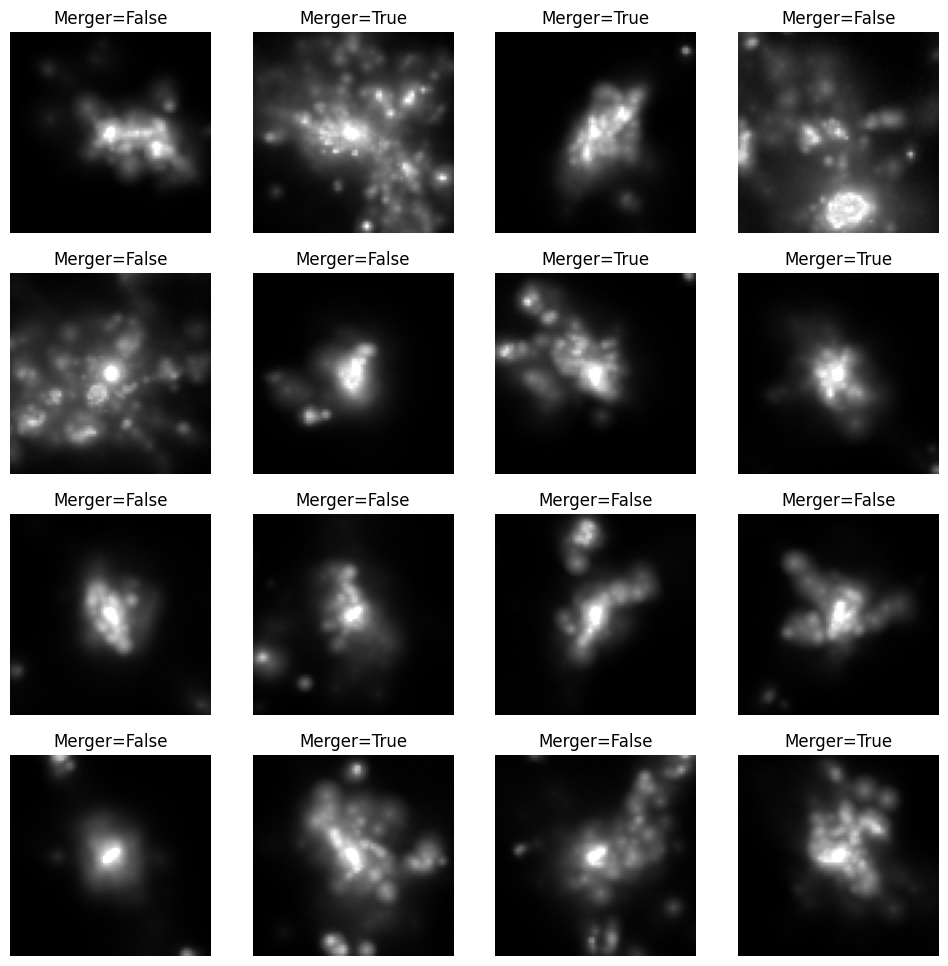

In [52]:
# set the random seed to get the same random set of images each time, or comment it out to get different ones!
np.random.seed(206265)

# select 16 random image indices:
example_ids = np.random.choice(hdu[1].data.shape[0], 16)
# pull the F160W image (index=1) from the simulated dataset for these selections
examples = [hdu[0].data[j, 1, :, :] for j in example_ids]

# initialize your figure
fig = plt.figure(figsize=(12, 12))

# loop through the randomly selected images and plot with labels
for i, image in enumerate(examples):
    ax = fig.add_subplot(4, 4, i+1)
    norm = simple_norm(image, 'log', max_percent=99.75)

    ax.imshow(image, aspect='equal', cmap='binary_r', norm=norm)
    ax.set_title('Merger='+str(bool(hdu[1].data[example_ids[i]][0])))

    ax.axis('off')

plt.show()

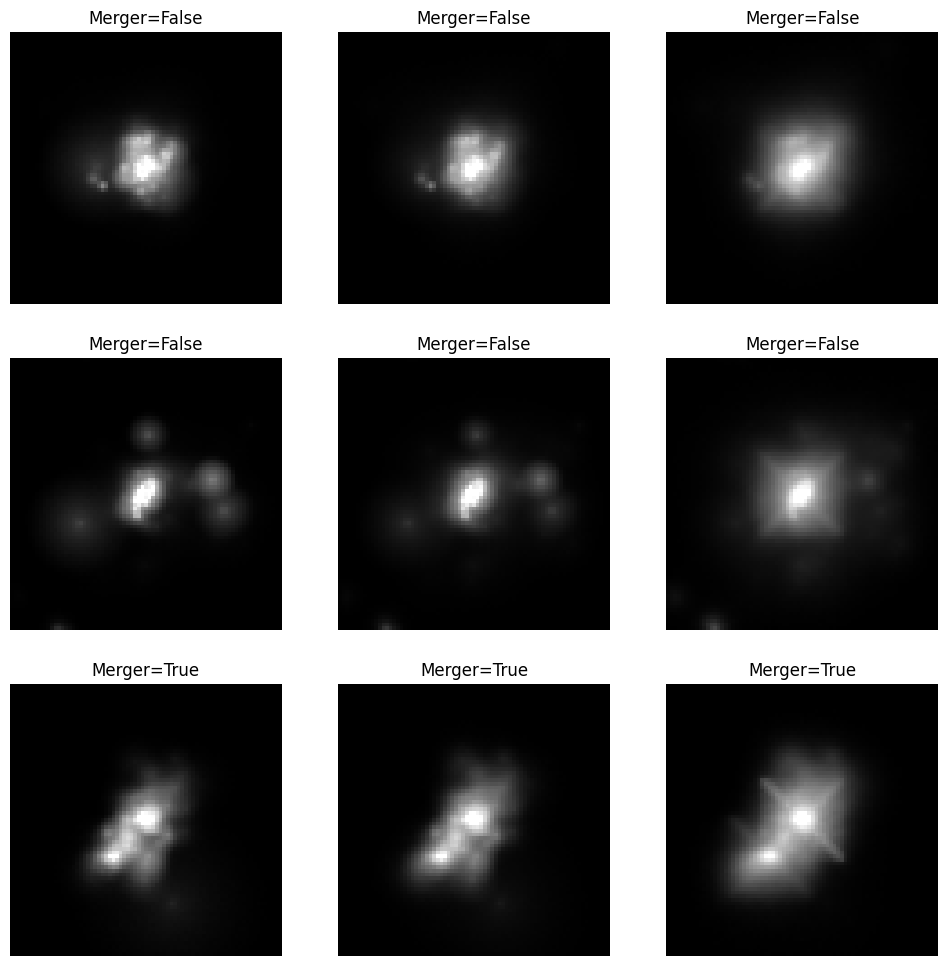

In [53]:
# set the random seed to get the same random set of images each time, or comment it out to get different ones!
np.random.seed(206261)

# select 16 random image indices:
example_ids = np.random.choice(hdu[1].data.shape[0], 3)
# pull the F814W image (index=0) from the simulated dataset for these selections
examples = [hdu[0].data[j, :, :, :] for j in example_ids]

# initialize your figure
fig = plt.figure(figsize=(12, 12))

# loop through the randomly selected images and plot with labels
imgcnt = 1
for i, image in enumerate(examples):
    for band in range (3):
     ax = fig.add_subplot(3, 3, imgcnt)
     norm = simple_norm(image[band], 'log', max_percent=99.75)

     ax.imshow(image[band], aspect='equal', cmap='binary_r', norm=norm)
     ax.set_title('Merger='+str(bool(hdu[1].data[example_ids[i]][0])))

     ax.axis('off')
     imgcnt += 1

plt.show()

We will denote the input images as X and their corresponding labels (i.e. the integer indicating whether or not they are a merger) as y, following the convention used by sklearn.



In [54]:
X = np.asarray(hdu[0].data).astype('float32')
y = np.asarray(hdu[1].data).astype('float32')

In [55]:
# as above, set the random seed to randomly split the images in a repeatable way. Try different values!
random_state = 206261

# First split off 30% of the data for validation+testing

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.3, random_state=random_state)

# Then divide this subset into training and testing sets

X_test, X_val, y_test, y_val = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=random_state)

Next, reshape the image array as follows: (number_of_images, image_width, image_length, 3). This is a “channels last” approach, where the final axis denotes the number of “spectral bands”. CNN’s will work with an arbitrary number of channels.

In [56]:
imsize = np.shape(X_train)[2]

X_train = X_train.reshape(-1, imsize, imsize, 3)
X_valtest = X_valtest.reshape(-1, imsize, imsize, 3)
X_test = X_test.reshape(-1, imsize, imsize, 3)
X_val = X_val.reshape(-1, imsize, imsize, 3)

X_train.shape, X_valtest.shape, 

((10798, 75, 75, 3), (4628, 75, 75, 3))

Now, we will build the CNN.

Further details about Conv2D, MaxPooling2D, BatchNormalization, Dropout, and Dense layers can be found in the Keras Layers Documentation. https://keras.io/api/layers/

Further details about the sigmoid and softmax activation function can be found in the Keras Activation Function Documentation. https://keras.io/api/layers/activations/

In [57]:
#Place your CNN here
from keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


def define_model(initial_input_shape):
    
    model = Sequential()
    model.add(Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=initial_input_shape))
    model.add(BatchNormalization()) #  Bright galaxies can have different brightnesses, so we normalize the data, this is something we dind't do in cats and dogs
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=initial_input_shape))
    model.add(BatchNormalization()) #  Bright galaxies can have different brightnesses, so we normalize the data, this is something we dind't do in cats and dogs
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=initial_input_shape))
    model.add(BatchNormalization()) #  Bright galaxies can have different brightnesses, so we normalize the data, this is something we dind't do in cats and dogs
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(64, activation='softmax', kernel_regularizer=l2(0.0001)))
    model.add(Dense(32, activation='softmax', kernel_regularizer=l2(0.0001)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # opt = SGD(learning_rate=0.01, momentum=0.9)
    opt = Adam(learning_rate=0.001)
    
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    
    return model
    
    

Next, we compile the model. You can use the Adam opmimizer and the binary cross entropy loss function (as this is a binary classification problem).

You can learn more about optimizers and more about loss functions for regression tasks in the Keras documentation.

In [58]:
from keras.optimizers import Adam

#Train your network here

nb_epoch = 300
batch_size = 512
shuffle = True

stop_early = EarlyStopping(monitor='val_loss', patience=100)

model = define_model(X_train.shape[1:])


/home/omirako/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 71, 71, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 71, 71, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 35, 35, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 35, 35, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 33, 33, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 33, 33, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,169 (426.44 KB)

 Trainable params: 109,057 (426.00 KB)

 Non-trainable params: 112 (448.00 B)

In [59]:
with tf.device('/GPU:0'):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=nb_epoch, batch_size=batch_size, shuffle=shuffle, callbacks=[stop_early])

Epoch 1/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - accuracy: 0.5236 - loss: 0.7070 - val_accuracy: 0.5246 - val_loss: 0.7003
Epoch 2/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5198 - loss: 0.6991 - val_accuracy: 0.5246 - val_loss: 0.6958
Epoch 3/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5238 - loss: 0.6951 - val_accuracy: 0.5246 - val_loss: 0.6938
Epoch 4/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5134 - loss: 0.6943 - val_accuracy: 0.5246 - val_loss: 0.6929
Epoch 5/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5232 - loss: 0.6925 - val_accuracy: 0.5246 - val_loss: 0.6920
Epoch 6/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5281 - loss: 0.6912 - val_accuracy: 0.5246 - val_loss: 0.6909
Epoch 7/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5294 - loss: 0.6899 - val_accuracy: 0.5246 - val_loss: 0.6902
Epoch 8/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5269 - loss: 0.6886 - val_accuracy: 0

To visualize the performance of the CNN, we plot the evolution of the accuracy and loss as a function of training epochs, for the training set and for the validation set.

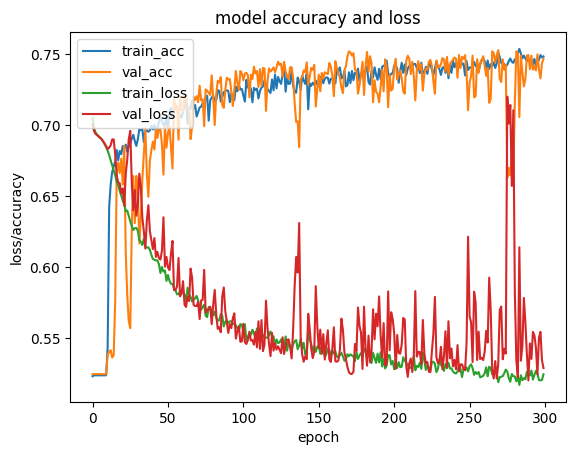

In [60]:
# Plot (accuracy, val accuracy, loss and val loss) vs epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy and loss')
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='upper left')
plt.show()

Observe how the loss for the validation set is higher than for the training set (and conversely, the accuracy for the validation set is lower than for the training set), suggesting that this model is suffering from overfitting.

Over-fitting of the network model is mitigated by the use of regularization through dropout of some % during training, applied after all convolutional layers.

You can also recompile the model, train for many more epochs, and include a callback, in cnn.train e.g.,
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

Now Plot a confusion Matrix (Merger vs non-merger)

73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


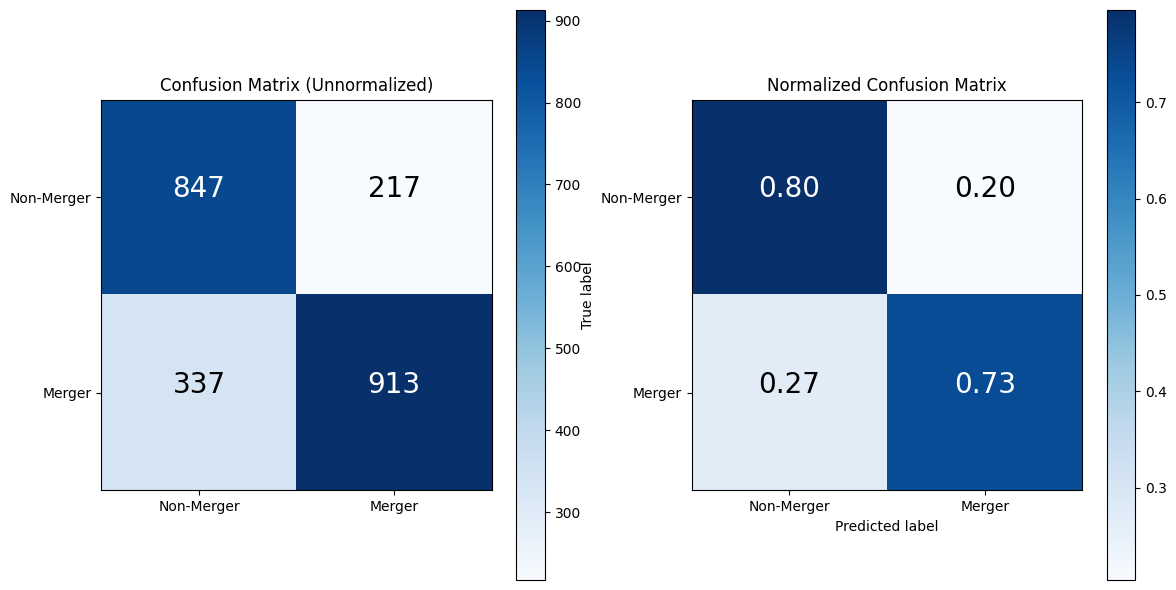

In [61]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get predictions
y_pred_prob = model.predict(X_test)  # Predict probabilities
threshold = 0.5  # Threshold for binary classification

# Apply thresholding to convert probabilities to binary predictions
y_pred_binary = (y_pred_prob >= threshold).astype(int)

# Generate confusion matrices
cm = confusion_matrix(y_test, y_pred_binary)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrices side by side
plt.figure(figsize=(12, 6))

# Plot non-normalized confusion matrix
plt.subplot(1, 2, 1)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Unnormalized)')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Merger', 'Merger'])
plt.yticks(tick_marks, ['Non-Merger', 'Merger'])
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=20)

# Plot normalized confusion matrix
thresh = cm_normalized.max() / 2.
plt.subplot(1, 2, 2)
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
plt.xticks(tick_marks, ['Non-Merger', 'Merger'])
plt.yticks(tick_marks, ['Non-Merger', 'Merger'])
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black",
                 fontsize=20)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Effect of noise? Try re-training the network with “noisy” data (i.e., modify
the version to “noisy” and download the associated data product). Do the results change? If so, how and why? What are the pros and cons of using noisy vs. pristine data to train a ML model?

Can I try a different model? You can try adding layers, changing the activation functions, swapping out the loss function, or trying a different optimizer or learning rate. Experiment and see what model changes give the best results.